In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
#from tqdm.notebook import tqdm

from train_test_aux import train, test

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


torch.Size([28, 28])


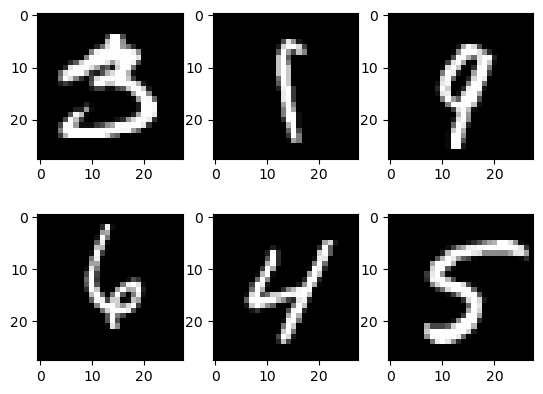

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)
print((sample_data[0][0]).size())

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

We build 4 main blocks
- Convolutional Block (conv+batchNorm+relu)
- Inception Block: each one consists of four parallel blocks
    1. Block 1: contain filter with kernel size of 1x1
    2. Block 2: contain filter with kernel size of 3x3
    3. Block 3: contain filter with kernel size of 5x5
    4. Block 4: contain max pooling layer with kernel size of 3x3 followed by filter with kernel size of 1x1
- Reduction Inception Block: each one consists of four parallel blocks
    1. Block 1: contain filter with kernel size of 1x1
    2. Block 2: contain filter with kernel size of 1x1 followed by filter with kernel size of 3x3 (3x3 reduce)
    3. Block 3: contain filter with kernel size of 1x1 followed by filter with kernel size of 5x5 (5x5 reduce)
    4. Block 4: contain max pooling layer with kernel size of 3x3 followed by filter with kernel size of 1x1
- Auxiliary Classifier Block: They are classifier heads we attach to layers before the end of the network. The motivation is to push useful gradients to the lower layers to make them immediately useful and improve the convergence during training by combatting the vanishing gradient problem

In [4]:
# Convolutional Block

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.conv_bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv_bn(self.conv(x)))
            
        return x

In [5]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, out_3x3, out_5x5, out_1x1pool):
        super(InceptionBlock, self).__init__()
        
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = ConvBlock(in_channels, out_3x3, kernel_size=3, padding=1)
        
        self.branch3 = ConvBlock(in_channels, out_5x5, kernel_size=5, padding=2)
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_1x1pool, kernel_size=1)
        )
        
    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )

In [6]:
class RedInceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(RedInceptionBlock, self).__init__()
        
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_1x1pool, kernel_size=1)
        )
        
    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )

In [7]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        
        self.adaptAvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.ReLU()
        
        self.conv = ConvBlock(in_channels, 24, kernel_size=1)
        self.fc1 = nn.Linear(24*4*4, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.adaptAvgPool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
class InceptionNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=10):
        super(InceptionNet, self).__init__()
        
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits
        
        self.conv1 = ConvBlock(in_channels=1, out_channels=8, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # In this order: in_channels, out_1x1, out_3x3, out_5x5, out_1x1pool
        self.inception3a = InceptionBlock(16, 8, 16, 8, 8)
        self.inception3b = InceptionBlock(40, 4, 20, 8, 8)
        self.inception3c = InceptionBlock(40, 16, 32, 16, 8)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception4a = RedInceptionBlock(72, 32, 20, 40, 12, 24, 16)
        self.inception4b = RedInceptionBlock(112, 24, 22, 44, 14, 28, 16)
        self.inception4c = RedInceptionBlock(112, 16, 24, 48, 16, 32, 16)
        self.inception4d = RedInceptionBlock(112, 16, 26, 54, 18, 38, 16)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.adaptAvgPool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(124, num_classes)
        
        if self.aux_logits:
            self.aux1 = InceptionAux(112, num_classes)
        else:
            self.aux1 = None
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.maxpool(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.inception3c(x)
        x = self.maxpool(x)
        
        x = self.inception4a(x)
        
        # Auxiliary Softmax classifier 1
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.maxpool(x)
        
        x = self.adaptAvgPool(x)
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.dropout(x)
        x = self.fc1(x)
        
        if self.aux_logits and self.training:
            return aux1, x
        else:
            return x

In [9]:
model = InceptionNet(aux_logits=True, num_classes=10)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionNet                             [64, 10]                  53,306
├─ConvBlock: 1-1                         [64, 8, 14, 14]           --
│    └─Conv2d: 2-1                       [64, 8, 14, 14]           392
│    └─BatchNorm2d: 2-2                  [64, 8, 14, 14]           16
│    └─ReLU: 2-3                         [64, 8, 14, 14]           --
├─MaxPool2d: 1-2                         [64, 8, 7, 7]             --
├─ConvBlock: 1-3                         [64, 16, 7, 7]            --
│    └─Conv2d: 2-4                       [64, 16, 7, 7]            1,152
│    └─BatchNorm2d: 2-5                  [64, 16, 7, 7]            32
│    └─ReLU: 2-6                         [64, 16, 7, 7]            --
├─MaxPool2d: 1-4                         [64, 16, 4, 4]            --
├─InceptionBlock: 1-5                    [64, 40, 4, 4]            --
│    └─ConvBlock: 2-7                    [64, 8, 4, 4]             --
│    │ 

In [10]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

[INFO]: Epoch 1 of 100
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.919, training acc: 62.485%
validation loss: 0.522, validation acc: 88.233%
--------------------------------------------------
[INFO]: Epoch 2 of 100
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.945, training acc: 90.144%
validation loss: 0.246, validation acc: 93.583%
--------------------------------------------------
[INFO]: Epoch 3 of 100
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 0.686, training acc: 93.456%
validation loss: 0.171, validation acc: 95.200%
--------------------------------------------------
[INFO]: Epoch 4 of 100
Training


  0%|          | 0/844 [00:00<?, ?it/s]

KeyboardInterrupt: 